<a href="https://colab.research.google.com/github/adeepe/Machine-Learning-CH2-PS316/blob/main/Training_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/25
406/406 [==============================] - 33s 66ms/step - loss: 42.4747 - mae: 6.3921
Epoch 2/25
406/406 [==============================] - 21s 53ms/step - loss: 18.0689 - mae: 3.2189
Epoch 3/25
406/406 [==============================] - 20s 49ms/step - loss: 0.4483 - mae: 0.5901
Epoch 4/25
406/406 [==============================] - 19s 46ms/step - loss: 0.4483 - mae: 0.5901
Epoch 5/25
406/406 [==============================] - 18s 45ms/step - loss: 0.4483 - mae: 0.5901
Epoch 6/25
406/406 [==============================] - 19s 47ms/step - loss: 0.4483 - mae: 0.5901
Epoch 7/25
406/406 [==============================] - 18s 45ms/step - loss: 0.4482 - mae: 0.5901
Epoch 8/25
406/406 [==============================] - 18s 43ms/step - loss: 0.4482 - mae: 0.5901
Epoch 9/25
406/406 [==============================] - 18s 44ms/step - loss: 0.4482 - mae: 0.5900
Epoch 10/25
406/406 [==============================] - 18s 45ms/step - loss: 0.4482 - mae: 0.5900
Epoch 11/25
406/406 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


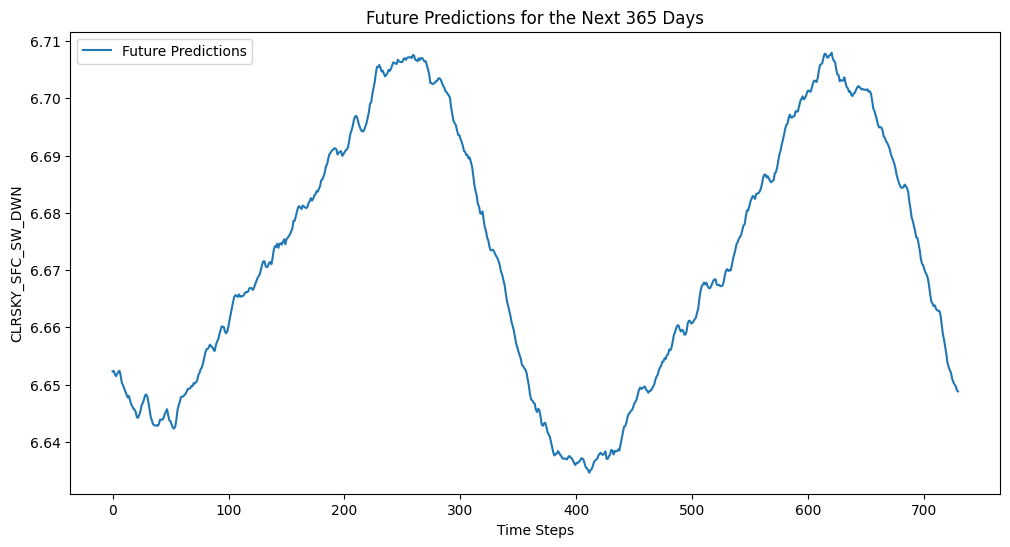

In [ ]:
import urllib
import os
import zipfile
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Fungsi ini mendownload dan mengekstrak dataset ke direktori yang berisi file ini.
def download_and_extract_dataset():
    url = 'https://raw.githubusercontent.com/adeepe/Machine-Learning-CH2-PS316/main/dataset_training_model.csv'
    df = pd.read_csv(url, sep=',', header=0)
    df['datetime'] = pd.to_datetime(df['DY'].astype(str) + '/' + df['MO'].astype(str) + '/' + df['YEAR'].astype(str), format='%d/%m/%Y')
    #df['day_of_year_fraction'] = df['datetime'].dt.dayofyear / 365.25
    #df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year_fraction'])
    df.set_index('datetime', inplace=True)
    df = df[['CLRSKY_SFC_SW_DWN']]
    window_size = 30
    df_filtered_smoothed = df.rolling(window=window_size, min_periods=1).mean()
    df_filtered_smoothed.columns = ['CLRSKY_SFC_SW_DWN_smoothed']
    df_result = pd.concat([df, df_filtered_smoothed], axis=1)
    df_final = df_result[['CLRSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN_smoothed']]

    N_FEATURES = df_final.shape[1]
    data = df_final.values
    data_normalized = normalize_series(data, data.min(axis=0), data.max(axis=0))
    return data, N_FEATURES

def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def windowed_dataset(series, batch_size, n_past=730, n_future=730, shift=1):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(n_past + n_future))
    dataset = dataset.map(lambda window: (window[:n_past], window[n_past:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def prepare_for_future_prediction(series, n_past):
    n_future = 365
    n_features = series.shape[1]  # Jumlah fitur Anda
    future_data = series[-n_past:].reshape((1, n_past, n_features))
    return future_data

def solution_C5():
    data, N_FEATURES = download_and_extract_dataset()

    BATCH_SIZE = 32
    N_PAST = 730
    N_FUTURE = 730
    SHIFT = 1

    train_set = windowed_dataset(data, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(N_PAST, N_FEATURES)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),  # Adjust the number of neurons and activation function
        tf.keras.layers.Dense(32, activation='relu'),  # Another hidden layer
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(N_FUTURE * N_FEATURES, activation='linear')
    ])

    model.add(tf.keras.layers.Reshape((N_FUTURE, N_FEATURES)))
    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

    history = model.fit(train_set, epochs=25)

    future_predictions = prepare_for_future_prediction(data, N_PAST)
    future_predictions = model.predict(future_predictions)

    return model, future_predictions

if __name__ == '__main__':
    trained_model, future_predictions = solution_C5()
    trained_model.save("model_C5.h5")

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(future_predictions.shape[1]), future_predictions[0, :, 0], label='Future Predictions')
    plt.title('Future Predictions for the Next 365 Days')
    plt.xlabel('Time Steps')
    plt.ylabel('CLRSKY_SFC_SW_DWN')
    plt.legend()
    plt.show()